In [ ]:
import sys

sys.path.append('../')

### Продемонстрируем результат работы методов одномерного поиска минимума

функция `f(x) = -sin(x)` на интервали `[0, 4]`

In [ ]:

from tqdm import tqdm

from core.extended_functions import *
from search.grad import *
from utils.matplotlib_utils import draw_grid

RANGE = Range(0, 4)

TARGET_EPS = [1, 0.1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8][::-1]

fib = Fib()
ENGINES = {
    "dichotomy": Dichotomy(find_min=True),
    "golden section": GoldenSection(find_min=True),
    "fibonacci": Fibonacci(fib)
}

RESULT = {}

for eps in tqdm(TARGET_EPS):
    RESULT[eps] = {}
    for e_name, e in ENGINES.items():
        RESULT[eps][e_name] = e.search(RANGE, MinusSin1(), eps)

engines_cnt = len(ENGINES)


def by_eps_plot(title: str, items: dict):
    def inner(ax):
        ax.set_title(title)
        for k, (xx, yy) in items.items():
            x_labels = list(map(str, xx))
            x_ticks = list(range(len(xx)))

            ax.set_xlabel('Eps')
            ax.set_xticks(x_ticks)
            ax.set_xticklabels(x_labels)
            ax.plot(x_ticks, yy, label=k)
        ax.legend()

    return inner


def range_plt(e_name: str, eps: float):
    def _inner(ax):
        ax.set_title(f'Ranges for {e_name}[eps = {eps}]')
        res: SearchResult = RESULT[eps][e_name]

        ranges = res.ranges

        yy = list(range(res.iterations))

        xx_left = []
        xx_right = []

        for r in ranges:
            xx_left.append(r.left)
            xx_right.append(r.right)

        ax.plot(xx_left, yy)
        ax.plot(xx_right, yy)

    return _inner


iter_by_eps = {}
calls_by_eps = {}
results_by_eps = {}

for e_name in ENGINES.keys():
    xx = []
    iter_yy = []
    calls_yy = []
    results_yy = []
    for eps in TARGET_EPS:
        xx.append(eps)
        res: SearchResult = RESULT[eps][e_name]
        iter_yy.append(res.iterations)
        calls_yy.append(res.calls_count)
        results_yy.append(res.x)

    iter_by_eps[e_name] = (xx, iter_yy)
    calls_by_eps[e_name] = (xx, calls_yy)
    results_by_eps[e_name] = (xx, results_yy)

grid = [
    by_eps_plot("Iterations by eps", iter_by_eps),
    by_eps_plot("Calls by eps", calls_by_eps),
    by_eps_plot("Result by eps", results_by_eps)
]

for e_name in ENGINES.keys():
    grid.append(range_plt(e_name, 1e-4))

draw_grid(grid, ncols=engines_cnt)

### Покажем результат работы метода градиентного спуска на некоторых примерах

In [ ]:
def draw_grad_des(e_func: ExtendedFunction,
                  start: np.ndarray,
                  strategy: StepStrategy,
                  max_iters=30,
                  initial_step=1):
    def _drawer(ax):
        grad = GradDescent()

        trace = {
            'x': [],
            'y': [],
            'f': []
        }

        def tracer(iter_n, point: np.ndarray):
            assert point.shape == (2,), f'Expected 2, got {len(point[0])}'

            trace['x'].append(point[0])
            trace['y'].append(point[1])
            trace['f'].append(e_func(point))

        found = grad.search(
            f=e_func,
            start=start,
            step_strategy=strategy,
            max_iters=max_iters,
            initial_step=initial_step,
            before_iteration=tracer
        )

        tracer(-1, found)

        for key in trace.keys():
            trace[key] = np.array(trace[key])

        xs = trace['x']
        ys = trace['y']

        min_x, max_x, min_y, max_y = min(xs), max(xs), min(ys), max(ys)
        dx, dy = max_x - min_x, max_y - min_y
        expansion = 1
        x = np.arange(min_x - dx * expansion - 1, max_x + dx * expansion + 1, 0.01)
        y = np.arange(min_y - dy * expansion - 1, max_y + dy * expansion + 1, 0.01)
        xx, yy = np.meshgrid(x, y, sparse=True)

        z = e_func((xx, yy), unsafe=True)

        title = f'{e_func.name};{strategy.name};initial_step={initial_step}'
        ax.contour(x, y, z)
        ax.scatter(xs, ys, s=10, c="black", edgecolors="black")
        ax.plot(xs, ys, c="black")
        ax.set_title(title, fontsize=16)
        ax.set_xlabel("x", fontsize=12)
        ax.set_ylabel("y", fontsize=12)

    return _drawer


def default_one_dim_sup(name):
    def _inner(f):
        return OneDimOptStrategy(f, name, search_range=Range(0, 1000), eps=1e-9)

    return _inner


def grad_shower(func: ExtendedFunction,
                start_point: np.ndarray,
                strategy_sup: Callable[[ExtendedFunction], StepStrategy],
                max_iters=15,
                initial_steps=(0.01, 0.1, 1, 10)
                ):
    strategy = strategy_sup(func)
    data = [draw_grad_des(func, start_point, strategy, initial_step=s, max_iters=max_iters) for s in initial_steps]

    draw_grid(data, ncols=2)


SUPPLIERS = [
    DividePrevStrategy,
    default_one_dim_sup('dichotomy'),
    default_one_dim_sup('golden'),
    default_one_dim_sup('fibonacci')
]

фукция `f(x,y) = x^2 + y^2` c начальной точкой `[10, 8]`

In [ ]:
for s in SUPPLIERS:
    grad_shower(func=Paraboloid(),
                start_point=np.array([10, 8]),
                strategy_sup=s
                )

фукция `f(x,y) = x^2 + 10 * y^2 + 5` c начальной точкой `[6, -8]`
"""
# %%
func = DelegateFunction(
    func=lambda p: p[0] ** 2 + 10 * p[1] ** 2 + 5,
    grad_func=lambda p: np.array([2 * p[0], 20 * p[1]])
)

for s in SUPPLIERS:
    grad_shower(func=func,
                start_point=np.array([6, -8]),
                strategy_sup=s
                )

### Рассмотрим градиентный спуск на квадратичных формах, используя разные размерности и числа обусловленности

100%|██████████| 4/4 [00:03<00:00,  1.14it/s]


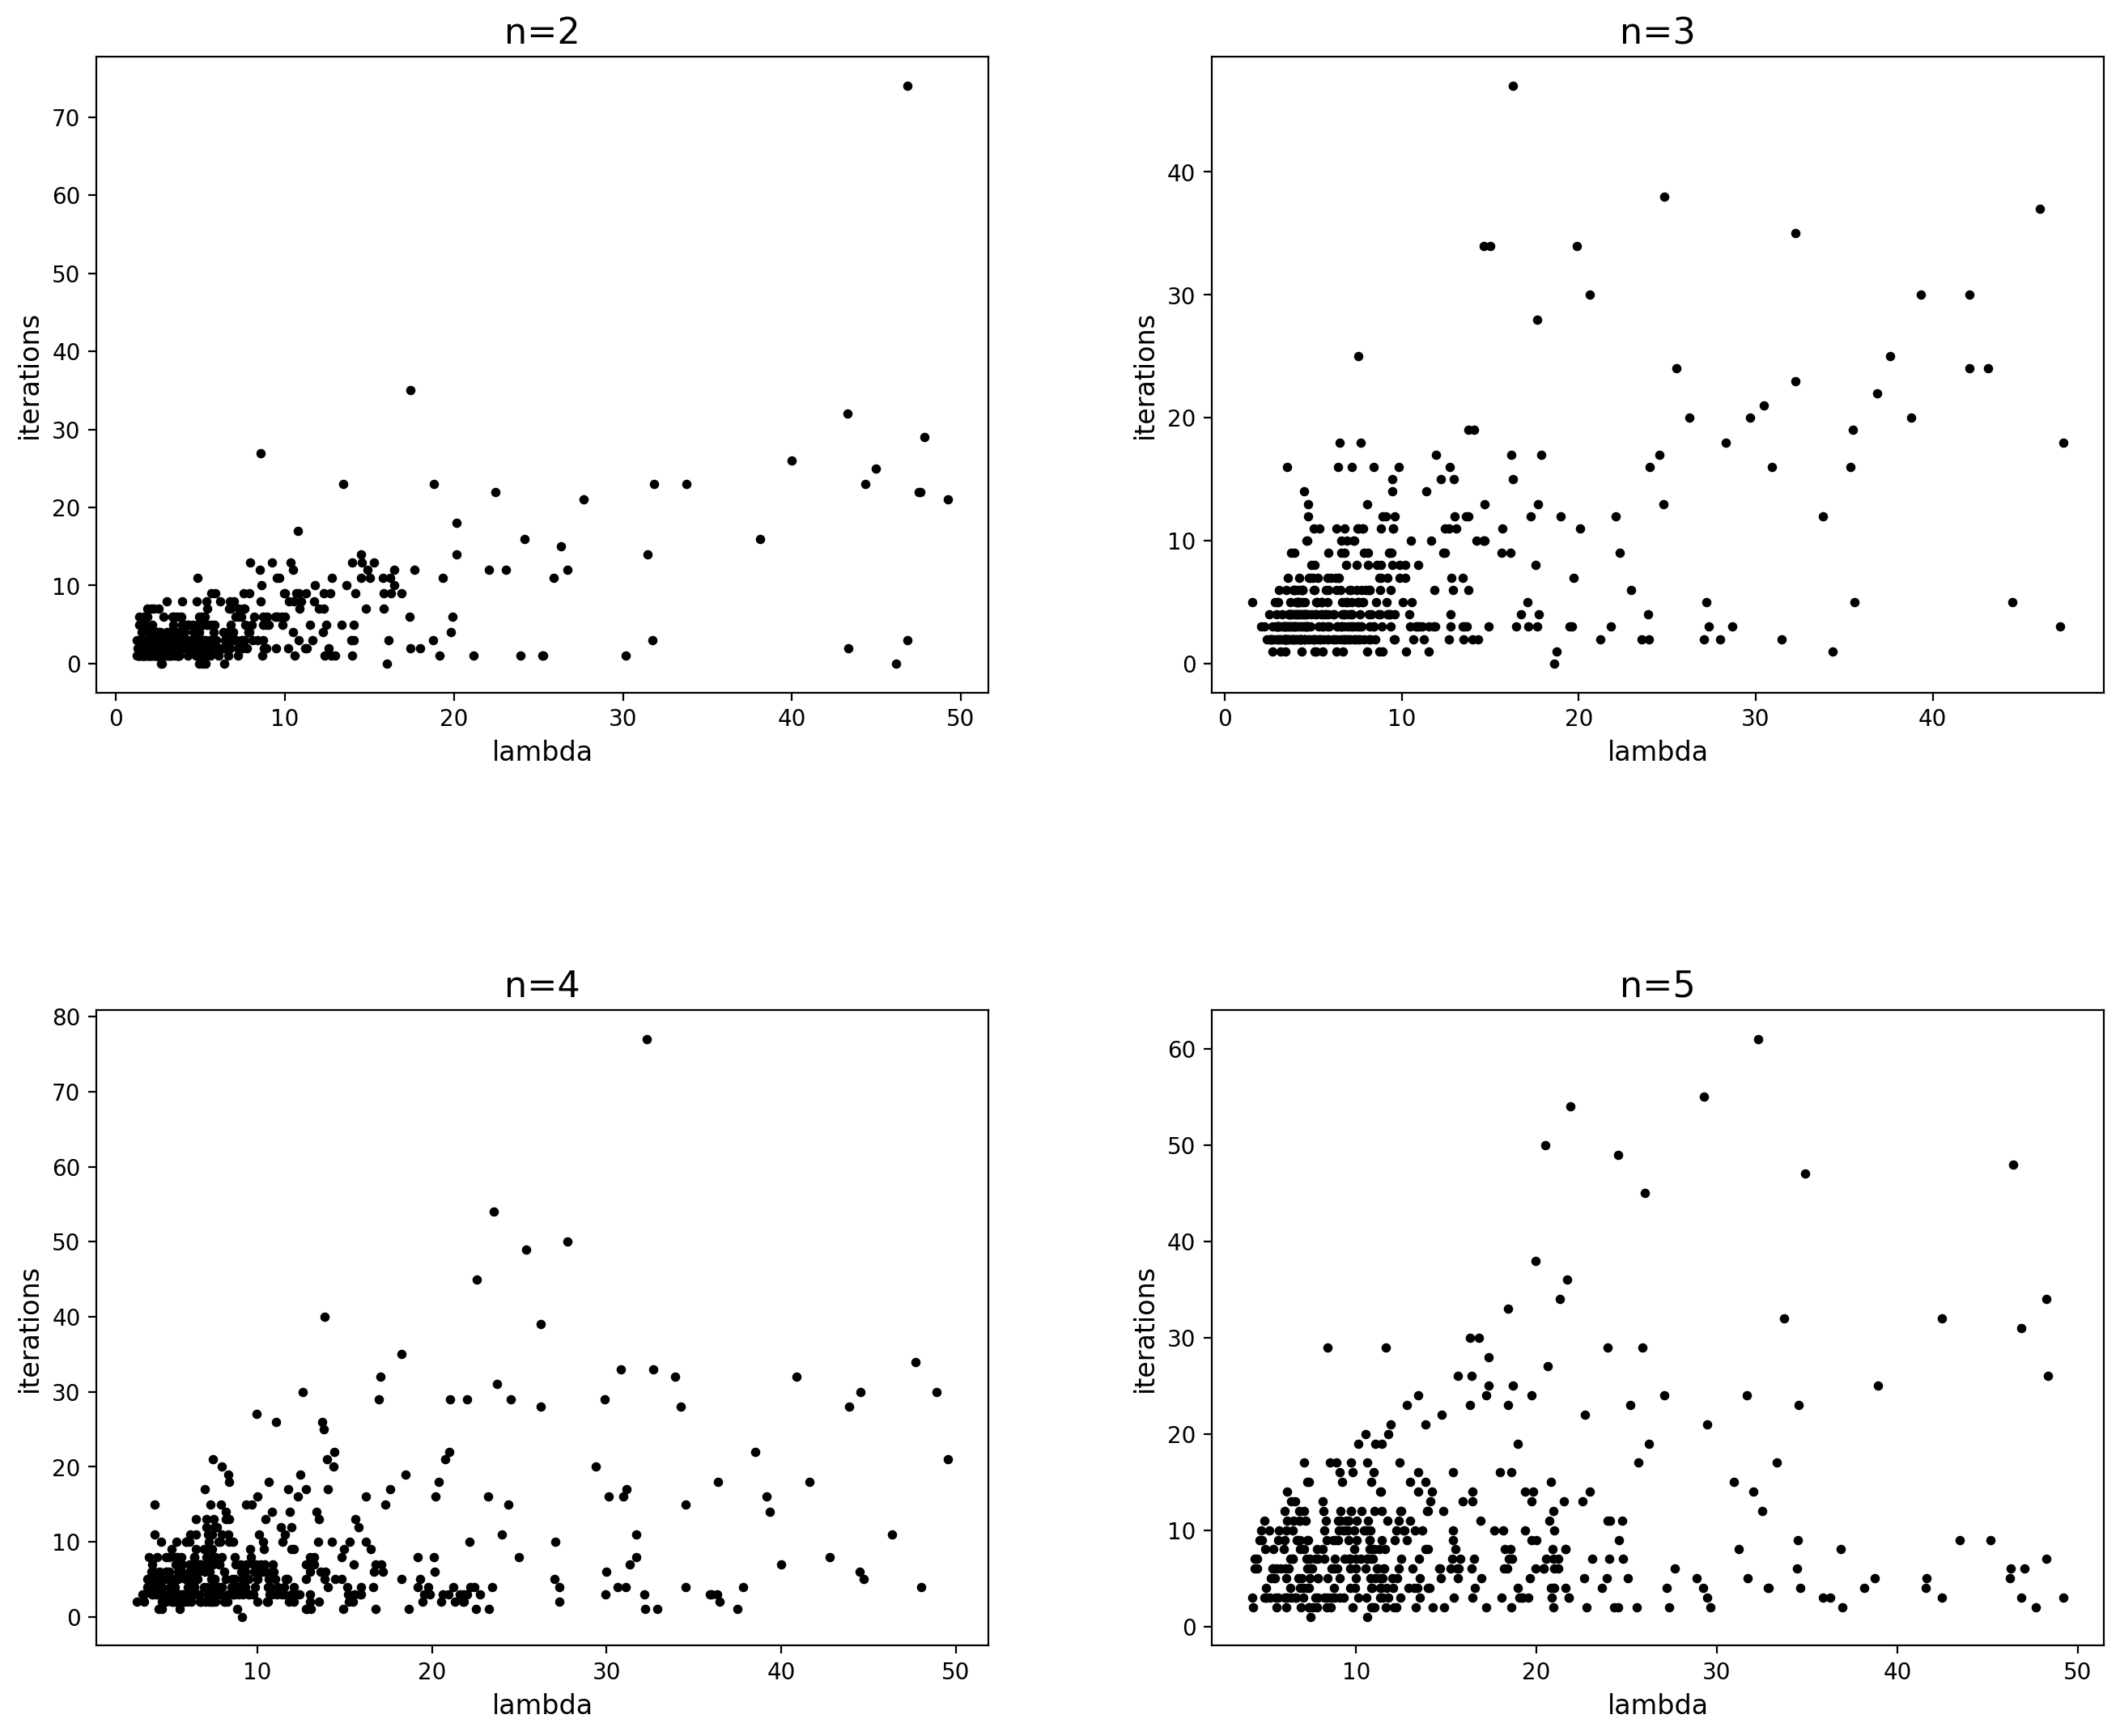

In [14]:

def get_point(matrix: np.ndarray, b: np.ndarray, c: float, x: np.ndarray) -> int:
    f = QuadraticFunction(matrix, b, c)

    _, iterations = GradDescent().search_with_iterations(f,
                                                         x,
                                                         step_strategy=DividePrevStrategy(f),
                                                         stop_criterion="func_margin",
                                                         eps=1e-3)
    return iterations


def gen_positive_matrix(n: int) -> np.ndarray:
    while True:
        matrix = np.random.random((n, n))
        if np.all(np.linalg.eigvals(matrix) > 0):
            return matrix


def draw_test_grad_util(n: int, points: List[Tuple[float, int]], ax):
    xs, ys = zip(*points)
    ax.scatter(xs, ys, s=10, c="black", edgecolors="black")

    ax.set_title(f'n={n}', fontsize=16)
    ax.set_xlabel("lambda", fontsize=12)
    ax.set_ylabel("iterations", fontsize=12)


def draw_one_test_grad(n: int, max_l=50, iterations=500):
    def _draw(ax):
        points = list()
        for i in range(1, iterations):
            matrix = gen_positive_matrix(n)
            b = np.random.random(n) - 0.5
            x = np.random.random(n)
            lambdas = np.abs(np.linalg.eigvals(matrix))
            l = max(lambdas) / min(lambdas)
            if l <= max_l:
                iters = get_point(matrix, b, 0.5, x)
                points.append((l, iters))
        points.sort(key=lambda pair: pair[0])
        draw_test_grad_util(n, points, ax)
    return _draw


def draw_test_grad():
    data = [draw_one_test_grad(n) for n in range(2, 6)]
    draw_grid(data, ncols=2)

draw_test_grad()
